# 相似变换-ICP算法

假设源点到目标点的变换是相似变换(Similarity transformation)即$p_t = sRp_s + t, s \in \mathscr{R}, t \in \mathscr{R}^3, R \in SO(3)$，如何求解变换参数呢？
其中R的求解方法与ICP算法相同,比例系数s和平移量t求解如下所示。

$$s^* = \frac{\sum \limits_i(y_i - \bar{y})^T R^* (x_i - \bar{x})}{\sum \limits_i(x_i - \bar{x})^T(x_i - \bar{x})}$$
$$ t^* = s^{*}R^{*}\bar{x} - \bar{y}$$
证明过程与ICP算法类似，这里不再展开。

## 例子
下面给出二维情况下已知点对应关系用ICP算法求解最优$s，R，t$的例子。

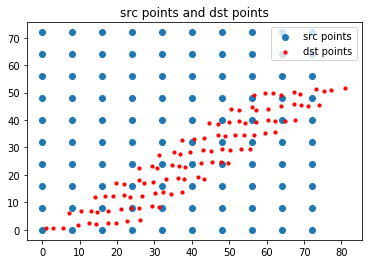

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
# SO(2) R, t examples
# global_transform = "similarity"
global_transform = "affine"

cell_size = 8.0
pts_row = 10
pts_col = 10
pts_num = pts_row * pts_col
    
# construct src points(grid)
src_pts = np.array([[[i * cell_size, j * cell_size] for i in range(pts_col)] 
                    for j in range(pts_row)], dtype=np.float32)
src_pts = src_pts.reshape(-1, 2)

# construct dst points(add random noise and global affine transform)
delta_pts = np.random.rand(pts_num, 2)
dst_pts = src_pts + delta_pts * 2
if global_transform == "similarity":
    # similarity transform matrix
    center = np.random.rand(2) * np.array([pts_col, pts_row]) * cell_size
    print(center)
    g_mat = cv2.getRotationMatrix2D(tuple(center), 
                                    float(np.random.rand(1)) * 360, 
                                    float(np.random.rand(1) * 2))    
elif global_transform == "affine":    
    # arbitary affine matrix
    g_mat = np.random.rand(2, 3)


dst_pts = np.concatenate([dst_pts, np.ones([pts_num, 1], dtype=np.float32)], 
                                 axis=1) @ g_mat.T

src_x = src_pts[:, 0]
src_y = src_pts[:, 1]
dst_x = dst_pts[:, 0]
dst_y = dst_pts[:, 1]
plt.title("src points and dst points")
plt.scatter(src_x, src_y, label="src points")
plt.scatter(dst_x, dst_y, c="r", s=10, label="dst points")
plt.legend()
plt.show()


[[17618.2829392   1550.67809338]
 [40385.94257111 35311.89465622]]
R_star =  [[ 0.80626114  0.59155979]
 [-0.59155979  0.80626114]]
s_star =  0.6216754343355233
t_star =  [[ 9.57309315]
 [21.26138713]]
mat_star =  [[ 0.50123274  0.36775819  9.57309315]
 [-0.36775819  0.50123274 21.26138713]]


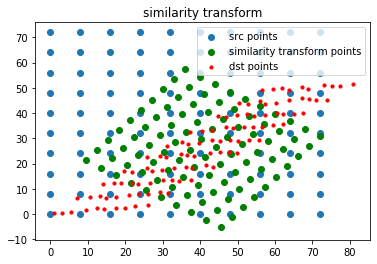

In [29]:
# calculate s, R, t and transform src_pts to dst_pts
mean_src_pts = np.mean(src_pts, axis=0).reshape(1, 2)
mean_dst_pts = np.mean(dst_pts, axis=0).reshape(1, 2)
cov_mat = (src_pts - mean_src_pts).T @ (dst_pts - mean_dst_pts) 
print(cov_mat)
u, sigma, vt = np.linalg.svd(cov_mat)
R_star = vt.T @ u.T
print("R_star = ", R_star)
s_star = np.sum(sigma) / np.sum((src_pts - mean_src_pts) ** 2) 
print("s_star = ", s_star)
t_star = (mean_dst_pts - mean_src_pts @ (s_star * R_star).T).reshape(2, 1)
print("t_star = ", t_star)
mat_star = np.concatenate([s_star * R_star, t_star], axis=1)
print("mat_star = ", mat_star)
trans_pts = np.concatenate([src_pts, np.ones([pts_num, 1], dtype=np.float32)], 
                         axis=1) @ mat_star.T


# plot
trans_x = trans_pts[:, 0]
trans_y = trans_pts[:, 1]
dst_x = dst_pts[:, 0]
dst_y = dst_pts[:, 1]

plt.title("similarity transform")
plt.scatter(src_x, src_y, label="src points")
plt.scatter(trans_x, trans_y, c="g", label="similarity transform points")
plt.scatter(dst_x, dst_y, c="r", s=10, label="dst points")
plt.legend()

plt.show()


(100, 2)


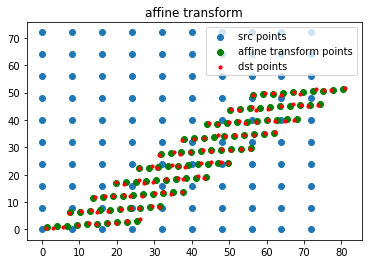

In [31]:
# calculate affine_matrix and transform src_pts to dst_pts
print(src_pts.shape)
homo_src_pts = np.concatenate([src_pts, np.ones([pts_num, 1], 
                               dtype=np.float32)], axis=1)
mat_A = np.kron(np.eye(2), homo_src_pts)
mat_b = dst_pts.T.reshape(-1, 1)
affine_mat = (np.linalg.pinv(mat_A) @ mat_b).reshape(2, 3)
# plot
affine_trans_pts = homo_src_pts @ affine_mat.T
affine_trans_x = affine_trans_pts[:, 0]
affine_trans_y = affine_trans_pts[:, 1]
dst_x = dst_pts[:, 0]
dst_y = dst_pts[:, 1]

plt.title("affine transform")
plt.scatter(src_x, src_y, label="src points")
plt.scatter(affine_trans_x, affine_trans_y, c="g", label="affine transform points")
plt.scatter(dst_x, dst_y, c="r", s=10, label="dst points")
plt.legend()

plt.show()